# Case Study #4: Data Bank
## B. Customer Transactions
### Case Study Questions
#### What is the unique count and total amount for each transaction type?
#### What is the average total historical deposit counts and amounts for all customers?
#### For each month - how many Data Bank customers make more than 1 deposit and either 1 purchase or 1 withdrawal in a single month?
#### What is the closing balance for each customer at the end of the month?
#### What is the percentage of customers who increase their closing balance by more than 5%?

### 1. What is the unique count and total amount for each transaction type?

* Use count to get the count of transaction type and SUM to add the transaction amount for each type

```sql
SELECT  txn_type AS transction_type,
	    COUNT(*) AS no_of_transctions,
        SUM(txn_amount) AS sum_of_transctions
FROM customer_transactions
GROUP BY txn_type;

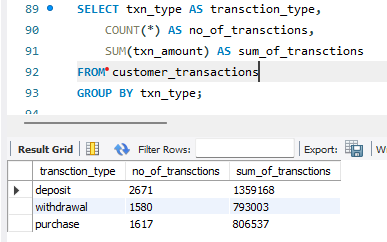

##### The transaction type "Deposit" has the highest count, with a total of 2671 occurrences and an accumulated amount of 1,359,168. Following closely is the transaction type "Purchase," which has been recorded 1,617 times, with a total amount of 806,537. On the other hand, "Withdrawal" has the lowest count of 1,580 instances, with a total amount of 793,003.

### 2. What is the average total historical deposit counts and amounts for all customers?

#### This query calculates the average number and amount of deposit transactions per customer by first summarizing each customer's total deposits using a CTE, then averaging those totals across all customers.

```sql
WITH CTE AS (
  SELECT customer_id, txn_type,
         COUNT(*) AS no_of_counts,
         SUM(txn_amount) AS total_amount
  FROM customer_transactions
  WHERE txn_type = 'deposit'
  GROUP BY customer_id, txn_type
)
SELECT
  txn_type,
  ROUND(AVG(no_of_counts), 0) AS AVG_DEPOSIT_COUNT,
  ROUND(AVG(total_amount), 2) AS AVG_DEPOSIT_AMOUNT
FROM CTE
GROUP BY txn_type;

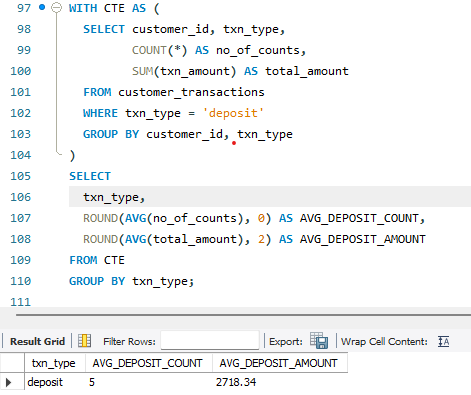

##### The average historical deposit count is 5 while the average amount is 2718.34

### 3. For each month - how many Data Bank customers make more than 1 deposit and either 1 purchase or 1 withdrawal in a single month?

#### This query finds, for each month, the number of customers who made more than one deposit and exactly one purchase or withdrawal in that month.

```sql
WITH month_cte AS (SELECT 
	date_format(txn_date,'%y-%m-01') AS month,
	customer_id,
	SUM(CASE WHEN txn_type = 'deposit' THEN 1 ELSE 0 END) AS deposit_count,
	SUM(CASE WHEN txn_type != 'deposit' THEN 1 ELSE 0 END) AS purchase_or_withdrawl
FROM 
	customer_transactions
GROUP BY 
	month, customer_id
HAVING (SUM(CASE WHEN txn_type = 'deposit' THEN 1 ELSE 0 END) > 1 AND 
        SUM(CASE WHEN txn_type != 'deposit' THEN 1 ELSE 0 END) = 1))
SELECT 
    month,
    COUNT(customer_id) AS customers
FROM month_cte
GROUP BY month;

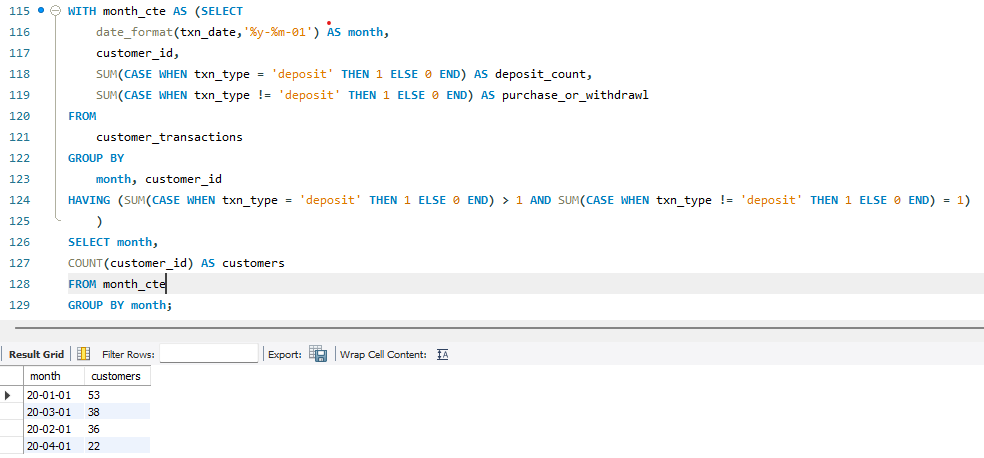

### The customer count was highest in January with 53 customers, followed by March with 38 customers, and Feb with 36 customers and April with 22 customers.

### 4. What is the closing balance for each customer at the end of the month?

#### This query calculates the closing balance for each customer at the end of every month by tracking daily net transactions and using a running total, then selecting the last transaction of each month per customer.

```sql
WITH total_txn AS 
(SELECT customer_id,
	date_format(txn_date,'%y-%m_01') AS months,
    txn_date,
    SUM(CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE 0 END)  - SUM(CASE WHEN txn_type != 'deposit' THEN txn_amount ELSE 0 END) AS balance
FROM 
	customer_transactions
GROUP BY 
	customer_id,txn_date, months
order by
	months, txn_date),
balance AS (SELECT *,
	SUM(balance) OVER(PARTITION BY customer_id ORDER BY txn_date) AS running_total,
	ROW_NUMBER() OVER(PARTITION BY customer_id, months ORDER BY txn_date DESC) AS rn
FROM total_txn)
SELECT customer_id,
	DATE_ADD(DATE_ADD(months, INTERVAL 1 MONTH), INTERVAL -1 DAY) AS end_of_month,
	running_total AS closing_balance
FROM balance
WHERE rn = 1
;

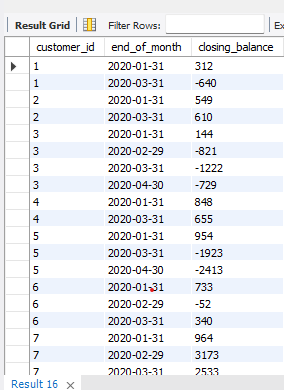

##### This query calculates the percentage of customers whose closing balance increases by more than 5% from one month to the next.
##### CTE: Calculates each customer's daily net balance from deposits and other transactions.
##### bal: Computes a running total (closing balance) and identifies the last transaction of each month.
##### closing_bal: Extracts each customer's month-end closing balance.
##### percentage_increase: Joins each month with the following month’s balance, calculates the percentage increase, and flags customers with a >5% increase.
##### Final SELECT: Computes the percentage of flagged customers.

```sql
-- Calculate daily net transaction balances
WITH CTE AS (
  SELECT 
    customer_id,
    txn_date,
    DATE_FORMAT(txn_date, '%Y-%m-01') AS month_start,
    SUM(CASE WHEN txn_type = 'deposit' THEN txn_amount ELSE 0 END) -
    SUM(CASE WHEN txn_type != 'deposit' THEN txn_amount ELSE 0 END) AS daily_balance
  FROM customer_transactions
  GROUP BY customer_id, txn_date
),

-- Compute running balance and rank the latest transaction of each month
bal AS (
  SELECT *,
    SUM(daily_balance) OVER (PARTITION BY customer_id ORDER BY txn_date) AS closing_balance,
    ROW_NUMBER() OVER (PARTITION BY customer_id, month_start ORDER BY txn_date DESC) AS rn
  FROM CTE
),

-- Get month-end closing balance per customer
closing_bal AS (
  SELECT 
    customer_id,
    DATE_ADD(DATE_ADD(month_start, INTERVAL 1 MONTH), INTERVAL -1 DAY) AS closing_month,
    DATE_ADD(month_start, INTERVAL -1 DAY) AS previous_month,
    closing_balance
  FROM bal
  WHERE rn = 1
),

-- Calculate percentage increase between months
percentage_increase AS (
  SELECT 
    c1.customer_id,
    c1.closing_balance AS prev_balance,
    c2.closing_balance AS next_balance,
    (c2.closing_balance - c1.closing_balance) / c1.closing_balance AS pct_increase,
    CASE 
      WHEN c1.closing_balance > 0 AND 
           (c2.closing_balance - c1.closing_balance) / c1.closing_balance > 0.05 
      THEN 1 ELSE 0 
    END AS flag
  FROM closing_bal c1
  INNER JOIN closing_bal c2
    ON c1.customer_id = c2.customer_id 
   AND c2.previous_month = c1.closing_month
)

-- Final percentage output
SELECT 
  ROUND(100.0 * SUM(flag) / COUNT(flag), 2) AS percent_customers_increased
FROM percentage_increase;


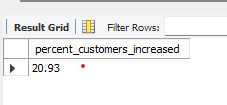